In [7]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/data/tim/heronWorkspace/src")
sys.path.append("/data/tim/heronWorkspace/AE")
sys.path.append("/data/tim/heronWorkspace/classifier")
sys.path.append("/data/tim/heronWorkspace/")


from AEHeronModelV1 import AEHeronModel
from AEHeronModelV2 import CAEHeron
from lightning.pytorch.callbacks import ModelSummary
from torchsummary import summary
import HeronImageLoader
from torch.utils.data import DataLoader, BatchSampler
from matplotlib import pyplot as plt
import lightning.pytorch as pl
from lightning.pytorch.tuner import Tuner
import pandas as pd
from lightning.pytorch.loggers import CSVLogger
from MLPV1 import MLP, MLPMSEHeatMap
from models import MLPBasic, CAEBigBottleneck, CAESmallBottleneckWithLinear, MLPBasicHeatMap, CAEV1
import numpy as np
import torch.nn.functional as F
import torch
from torchvision.transforms import GaussianBlur
from PIL import Image, ImageFilter
import random
from scipy.stats import loguniform
from ClassifierDatasets import DatasetThreeConsecutive, UnNormalize
# from torchmetrics.image import StructuralSimilarityIndexMeasure
from skimage.metrics import structural_similarity as ssim
import seaborn as sns
from sklearn.model_selection import ParameterSampler
from scipy.stats import loguniform, uniform
import functorch
from sklearn.metrics import confusion_matrix
# from torchmetrics import ConfusionMatrix

sns.set_theme()




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Params:
- different CAE
- cameraProps - cutoff on the sides
- gaussian filter params / min-filter params
- zero thresholds
- sum threshold
- dataset props

In [8]:
loaderParams = dict(
    lblValidationMode = "Manual",
    balanced = True,
    anomalyObviousness = "obvious",
    distinctCAETraining = False,
    colorMode = "RGB",
    random_state = 1,
    set = "all"
)

distributions = dict(
    cameras = [["NEN1", "SBU3"]],
    balanced = [True, False],
    distinctCAETraining = [True, False],
    gaussianFilterSize = [5],
    gaussianFilterSigma = [3, 5, 7],
    filter = ["MinFilter"], #["MinFilter", "GaussianFilter"]
    zeroThreshold = uniform(0.15, 0.25), # loguniform(0.15, 0.4), #threshold for zeroing out the image
    sumThreshold = uniform(0.5, 20),
    lossFn = ["L1"]#["MSE", "L1"],
)

sampler = ParameterSampler(distributions, n_iter=10, random_state=loaderParams["random_state"])

includeCameraProps = False
model = CAEV1

checkPoint = '/data/tim/heronWorkspace/logs/CAEV1/version_3/checkpoints/epoch=49-step=19350.ckpt'
caeLoaded = CAEHeron.load_from_checkpoint(checkPoint, model = model)
caeLoaded.freeze()
print(caeLoaded.hparams)

fileName = "basicCAETest"
columns = ["trueLbl", "predictedLbl", "ImagePath", "includeCameraProps", "CAECheckPoint", "isCAETrainingCamera"] + list(loaderParams.keys()) + list(distributions.keys()) 
try:
    df = pd.read_csv(f"/data/tim/heronWorkspace/caeTestData/{fileName}.csv")
except:
    df = pd.DataFrame(columns=columns)


"batch_size":         16
"bottleneck":         128
"cameras":            ['NEN1', 'SBU3']
"gammaScheduler":     0.7879353477950641
"ldim":               16
"learning_rate":      0.003533238255084643
"num_workers_loader": 4
"transforms":         None
"weight_decay":       4.5387898639621974e-07


In [9]:
def min_filter(tensor, kernel_size=3):
    # Unfold the tensor into sliding local blocks
    unfolded = tensor.unfold(2, kernel_size, 1).unfold(3, kernel_size, 1)
    # Compute the minimum in each of these blocks
    return unfolded.min(dim=-1)[0].min(dim=-1)[0]

In [10]:
a = torch.tensor([[[0] * 5, [1] * 5, [2] * 5, [3] * 5, [4] * 5]]).unfold(1, 3, 1)
a.unfold(2, 3, 1)

tensor([[[[[0, 0, 0],
           [1, 1, 1],
           [2, 2, 2]],

          [[0, 0, 0],
           [1, 1, 1],
           [2, 2, 2]],

          [[0, 0, 0],
           [1, 1, 1],
           [2, 2, 2]]],


         [[[1, 1, 1],
           [2, 2, 2],
           [3, 3, 3]],

          [[1, 1, 1],
           [2, 2, 2],
           [3, 3, 3]],

          [[1, 1, 1],
           [2, 2, 2],
           [3, 3, 3]]],


         [[[2, 2, 2],
           [3, 3, 3],
           [4, 4, 4]],

          [[2, 2, 2],
           [3, 3, 3],
           [4, 4, 4]],

          [[2, 2, 2],
           [3, 3, 3],
           [4, 4, 4]]]]])

Length of dataset: 18
{'balanced': False, 'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': False, 'filter': 'MinFilter', 'gaussianFilterSigma': 3, 'gaussianFilterSize': 5, 'lossFn': 'L1', 'sumThreshold': 19.151147186773176, 'zeroThreshold': 0.18203111198233918}
[[ 0.          1.         49.70231247]
 [ 0.          1.         49.82901001]
 [ 0.          1.         49.64953232]
 [ 0.          1.         49.814785  ]
 [ 0.          1.         49.99646378]
 [ 0.          1.         49.67459106]
 [ 0.          1.         49.66547394]
 [ 1.          1.         49.79439545]
 [ 1.          1.         50.20623779]
 [ 1.          1.         49.67211533]
 [ 1.          1.         54.33518219]
 [ 1.          1.         49.73361206]
 [ 1.          1.         50.48670578]
 [ 1.          1.         50.68915558]
 [ 0.          1.         49.87984467]
 [ 0.          1.         51.59374619]
 [ 1.          1.         50.15819931]
 [ 1.          1.         49.98086548]]


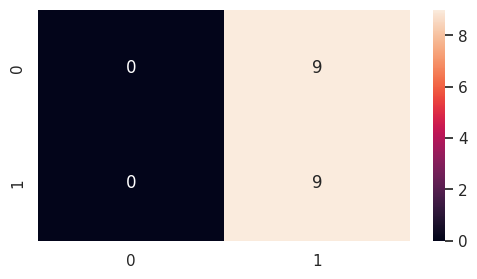

Length of dataset: 18
{'balanced': False, 'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': False, 'filter': 'MinFilter', 'gaussianFilterSigma': 3, 'gaussianFilterSize': 5, 'lossFn': 'L1', 'sumThreshold': 2.346771895375956, 'zeroThreshold': 0.19656505284441772}
[[ 0.          1.         53.65921783]
 [ 0.          1.         53.76800156]
 [ 0.          1.         53.61371231]
 [ 0.          1.         53.76600647]
 [ 0.          1.         53.93216324]
 [ 0.          1.         53.63486099]
 [ 0.          1.         53.62552643]
 [ 1.          1.         53.7475853 ]
 [ 1.          1.         54.15100479]
 [ 1.          1.         53.63283157]
 [ 1.          1.         58.24240875]
 [ 1.          1.         53.68948746]
 [ 1.          1.         54.42709351]
 [ 1.          1.         54.57976151]
 [ 0.          1.         53.82987976]
 [ 0.          1.         55.42205048]
 [ 1.          1.         54.10793304]
 [ 1.          1.         53.92733765]]


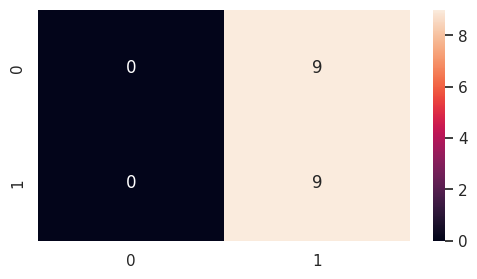

Length of dataset: 18
{'balanced': False, 'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': True, 'filter': 'MinFilter', 'gaussianFilterSigma': 7, 'gaussianFilterSize': 5, 'lossFn': 'L1', 'sumThreshold': 19.210781416120636, 'zeroThreshold': 0.36157772917150427}
[[  0.           1.          98.63289642]
 [  0.           1.          98.64498138]
 [  0.           1.          98.6213913 ]
 [  0.           1.          98.69038391]
 [  0.           1.          98.75159454]
 [  0.           1.          98.62228394]
 [  0.           1.          98.6213913 ]
 [  1.           1.          98.67621613]
 [  1.           1.          98.99718475]
 [  1.           1.          98.6235199 ]
 [  1.           1.         102.73098755]
 [  1.           1.          98.64873505]
 [  1.           1.          99.24207306]
 [  1.           1.          99.08148193]
 [  0.           1.          98.74478149]
 [  0.           1.          99.45509338]
 [  1.           1.          98.99176025]
 [  1.           1.   

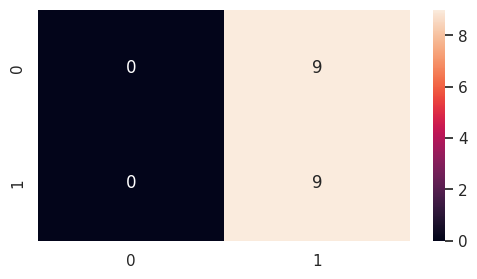

Length of dataset: 18
{'balanced': False, 'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': True, 'filter': 'MinFilter', 'gaussianFilterSigma': 3, 'gaussianFilterSize': 5, 'lossFn': 'L1', 'sumThreshold': 4.589044994630349, 'zeroThreshold': 0.3695293590977363}
[[  0.           1.         100.80109406]
 [  0.           1.         100.81186676]
 [  0.           1.         100.79024506]
 [  0.           1.         100.85690308]
 [  0.           1.         100.91520691]
 [  0.           1.         100.79090881]
 [  0.           1.         100.79024506]
 [  1.           1.         100.84234619]
 [  1.           1.         101.16010284]
 [  1.           1.         100.79205322]
 [  1.           1.         104.87885284]
 [  1.           1.         100.81616974]
 [  1.           1.         101.40354919]
 [  1.           1.         101.23527527]
 [  0.           1.         100.91051483]
 [  0.           1.         101.5957489 ]
 [  1.           1.         101.15563965]
 [  1.           1.     

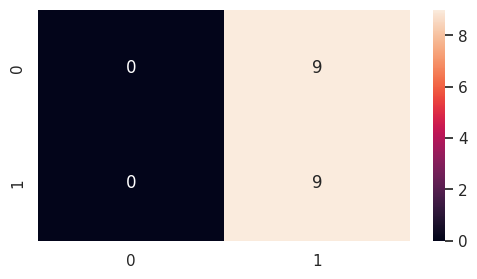

Length of dataset: 18
{'balanced': False, 'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': True, 'filter': 'MinFilter', 'gaussianFilterSigma': 7, 'gaussianFilterSize': 5, 'lossFn': 'L1', 'sumThreshold': 18.77924049158466, 'zeroThreshold': 0.26430120199674706}
[[ 0.          1.         72.11380768]
 [ 0.          1.         72.16213989]
 [ 0.          1.         72.08895111]
 [ 0.          1.         72.19644928]
 [ 0.          1.         72.30647278]
 [ 0.          1.         72.09738922]
 [ 0.          1.         72.09139252]
 [ 1.          1.         72.18435669]
 [ 1.          1.         72.54930878]
 [ 1.          1.         72.09828949]
 [ 1.          1.         76.48033905]
 [ 1.          1.         72.13919067]
 [ 1.          1.         72.81166077]
 [ 1.          1.         72.79039764]
 [ 0.          1.         72.25849152]
 [ 0.          1.         73.38973999]
 [ 1.          1.         72.52628326]
 [ 1.          1.         72.33387756]]


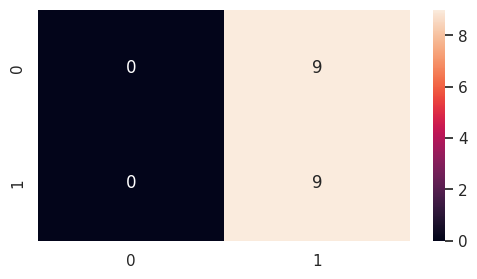

Length of dataset: 18
{'balanced': False, 'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': False, 'filter': 'MinFilter', 'gaussianFilterSigma': 7, 'gaussianFilterSize': 5, 'lossFn': 'L1', 'sumThreshold': 4.462029781697575, 'zeroThreshold': 0.35018614216888416}
[[ 0.          1.         95.52684021]
 [ 0.          1.         95.54110718]
 [ 0.          1.         95.51434326]
 [ 0.          1.         95.58686066]
 [ 0.          1.         95.65239716]
 [ 0.          1.         95.5157547 ]
 [ 0.          1.         95.51434326]
 [ 1.          1.         95.57331085]
 [ 1.          1.         95.89890289]
 [ 1.          1.         95.51704407]
 [ 1.          1.         99.65448761]
 [ 1.          1.         95.5437851 ]
 [ 1.          1.         96.14571381]
 [ 1.          1.         95.99681854]
 [ 0.          1.         95.64239502]
 [ 0.          1.         96.39057159]
 [ 1.          1.         95.89200592]
 [ 1.          1.         95.69817352]]


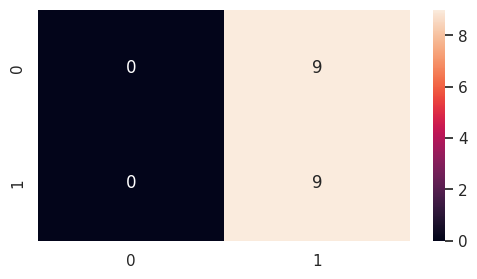

Length of dataset: 18
{'balanced': False, 'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': False, 'filter': 'MinFilter', 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'lossFn': 'L1', 'sumThreshold': 14.346452313386282, 'zeroThreshold': 0.36909728807400954}
[[  0.           1.         100.6832962 ]
 [  0.           1.         100.69413757]
 [  0.           1.         100.67241669]
 [  0.           1.         100.73918915]
 [  0.           1.         100.79764557]
 [  0.           1.         100.67308807]
 [  0.           1.         100.67241669]
 [  1.           1.         100.72465515]
 [  1.           1.         101.04259491]
 [  1.           1.         100.67424011]
 [  1.           1.         104.76213837]
 [  1.           1.         100.69841003]
 [  1.           1.         101.28611755]
 [  1.           1.         101.11824799]
 [  0.           1.         100.79285431]
 [  0.           1.         101.47943115]
 [  1.           1.         101.03807068]
 [  1.           1.  

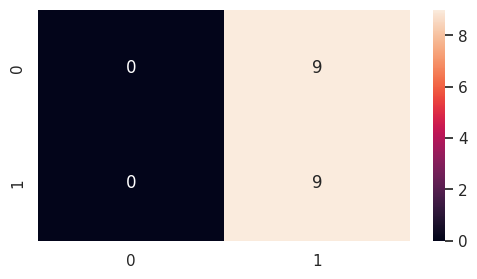

Length of dataset: 18
{'balanced': True, 'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': False, 'filter': 'MinFilter', 'gaussianFilterSigma': 3, 'gaussianFilterSize': 5, 'lossFn': 'L1', 'sumThreshold': 17.09206718788367, 'zeroThreshold': 0.21826249355418684}
[[ 0.          1.         59.56858063]
 [ 0.          1.         59.65410233]
 [ 0.          1.         59.53174973]
 [ 0.          1.         59.66727448]
 [ 0.          1.         59.81274414]
 [ 0.          1.         59.54788208]
 [ 0.          1.         59.5391922 ]
 [ 1.          1.         59.65132523]
 [ 1.          1.         60.04188919]
 [ 1.          1.         59.54693222]
 [ 1.          1.         64.07950592]
 [ 1.          1.         59.59768295]
 [ 1.          1.         60.31299973]
 [ 1.          1.         60.39989471]
 [ 0.          1.         59.73031616]
 [ 0.          1.         61.15564346]
 [ 1.          1.         60.00600052]
 [ 1.          1.         59.82102966]]


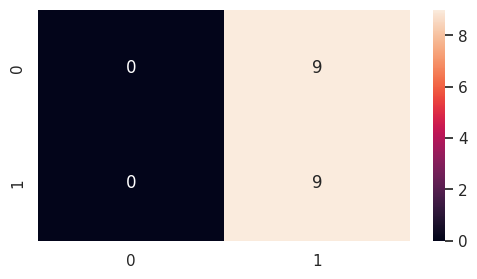

Length of dataset: 18
{'balanced': True, 'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': False, 'filter': 'MinFilter', 'gaussianFilterSigma': 3, 'gaussianFilterSize': 5, 'lossFn': 'L1', 'sumThreshold': 2.466936676661002, 'zeroThreshold': 0.25527690625126304}
[[ 0.          1.         69.65418243]
 [ 0.          1.         69.70857239]
 [ 0.          1.         69.62750244]
 [ 0.          1.         69.7399292 ]
 [ 0.          1.         69.85592651]
 [ 0.          1.         69.6370163 ]
 [ 0.          1.         69.63071442]
 [ 1.          1.         69.72738647]
 [ 1.          1.         70.09688568]
 [ 1.          1.         69.63777924]
 [ 1.          1.         74.04790497]
 [ 1.          1.         69.6805191 ]
 [ 1.          1.         70.36105347]
 [ 1.          1.         70.35834503]
 [ 0.          1.         69.80213928]
 [ 0.          1.         70.98548126]
 [ 1.          1.         70.07167816]
 [ 1.          1.         69.88040161]]


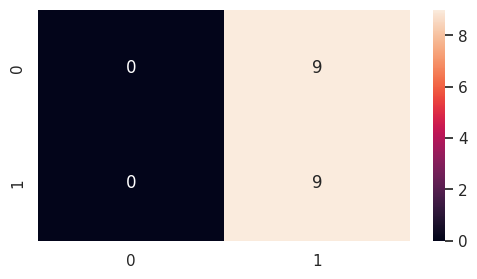

Length of dataset: 18
{'balanced': False, 'cameras': ['NEN1', 'SBU3'], 'distinctCAETraining': False, 'filter': 'MinFilter', 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'lossFn': 'L1', 'sumThreshold': 4.4510179596956245, 'zeroThreshold': 0.2224074101364531}
[[ 0.          1.         60.69761658]
 [ 0.          1.         60.77920914]
 [ 0.          1.         60.66226578]
 [ 0.          1.         60.79493332]
 [ 0.          1.         60.93668365]
 [ 0.          1.         60.67751312]
 [ 0.          1.         60.66907501]
 [ 1.          1.         60.77937317]
 [ 1.          1.         61.16746521]
 [ 1.          1.         60.67683411]
 [ 1.          1.         65.19510651]
 [ 1.          1.         60.72655106]
 [ 1.          1.         61.43783951]
 [ 1.          1.         61.51336288]
 [ 0.          1.         60.85783005]
 [ 0.          1.         62.25344086]
 [ 1.          1.         61.1329422 ]
 [ 1.          1.         60.94717789]]


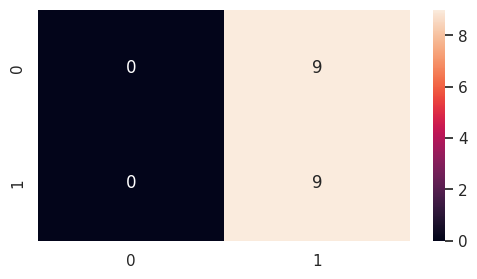

ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 600x300 with 0 Axes>

In [11]:
#TODO: include camerProps

# confMat = ConfusionMatrix(task="binary", num_classes=2)
unnorm = UnNormalize(mean=0.5, std=0.5)

for params in sampler:
    dataset = DatasetThreeConsecutive(cameras=params["cameras"], resize_to=CAEV1.imsize, **loaderParams)
    print(f'Length of dataset: {len(dataset)}')
    print(params)
    dataLoader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=2)

    blur = GaussianBlur(kernel_size=5, sigma=3) #TODO: make this a parameter
    lossFn = F.mse_loss if params["lossFn"] == "MSE" else F.l1_loss
    vals = []
    for (imArr, lblArr, camera, ImagePath) in dataLoader:
        isTrainingCamera = camera in caeLoaded.hparams.cameras
        prevImg = imArr[0] #alwasy #batch_size images
        currImg = imArr[1]
        nextImg = imArr[2]

        prevPred, currPred, nextPred = [unnorm(caeLoaded(x.to(caeLoaded.device))) for x in [prevImg, currImg, nextImg]]
        prevImg, currImg, nextImg = [unnorm(x) for x in [prevImg, currImg, nextImg]]

        prevImgBlurred, currImgBlurred, nextImgBlurred = [blur.forward(x).to(prevPred.device) for x in [prevImg, currImg, nextImg]]
        
        prevImd, currImd, nextImd = [torch.sum(F.mse_loss(imgBlurred, pred, reduction='none'), dim=1) for imgBlurred, pred in zip([prevImgBlurred, currImgBlurred, nextImgBlurred], [prevPred, currPred, nextPred])]

        prevToCurrImd = torch.clamp(torch.sub(currImd, prevImd), min= 0)
        nextToCurrImd = torch.clamp(torch.sub(currImd, nextImd), min= 0)

        prevNextCurrImd = torch.div(torch.add(prevToCurrImd, nextToCurrImd), 2)

        prevNextCurrImdMin = min_filter(prevNextCurrImd, kernel_size=3)
        
        prevNextCurrImdMin.clamp_(min=params["zeroThreshold"])

        sumPrevNextCurrImdMin = torch.div(torch.sum(prevNextCurrImdMin, dim=(1, 2)), 255)
        predictions = (sumPrevNextCurrImdMin> params["sumThreshold"]).to(torch.int)

        for i in range(len(predictions)):
            vals.append([lblArr[i].item(), predictions[i].item(), sumPrevNextCurrImdMin[i].item()])
        #     dfNew = pd.DataFrame(columns=columns, )
        #     dfNew = df.append(dict(zip(columns, [lblArr[i].item(), predictions[i].item(), ImagePath[i], includeCameraProps, checkPoint, isTrainingCamera] + list(loaderParams.values()) + list(params.values()))), ignore_index=True)
        
        # df.to_csv(f"/data/tim/heronWorkspace/caeTestData/{fileName}.csv", index=False)

        # print(predictions)
        # print(prevNextCurrImdMin.shape)
        # print(torch.max(prevNextCurrImdMin))
        # print(imArr[0].shape)
        # print(len(imArr))
        # print(len(lblArr))

    # confMat
    vals = np.array(vals)
    print(vals)
    # print(vals[:, 0])
    # print(vals[:, 1])
    confMat = confusion_matrix(vals[:, 0], vals[:,1])
    plt.figure(figsize = (6,3))
    sns.heatmap(confMat, annot=True)
    plt.show()
    vals = []

        

# confusionMatrix
confMat = confusion_matrix(df["trueLbl"], df["predictedLbl"])
plt.figure(figsize = (6,3))
sns.heatmap(confMat, annot=True)
plt.show()

In [ ]:
try:
    df = pd.read_csv("./resultsBasicClassifier.csv")
except:
    df = pd.DataFrame(columns = params.keys(), )